In [1]:
import pathlib
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB0
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

from data_augmentation import RandomColorDistortion

In [2]:
plt.rcParams["figure.dpi"] = 200

In [3]:
DATASET_PATH = "../../dataset/"

In [4]:
IMAGE_SIZE = (128, 128)
COLOR_MODE = "rgb"
BATCH_SIZE = 64

In [5]:
data = []
for file in pathlib.Path(DATASET_PATH).glob("*/*"):
    data.append({"filename": file.resolve().as_posix(), "label": file.resolve().parent.name})

In [6]:
df = pd.DataFrame(data)
df.head()

,filename,label
0,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/d...,badger
1,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/d...,badger
2,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/d...,badger
3,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/d...,badger
4,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/d...,badger


In [7]:
df[["dataset", "time"]] = df["filename"].str.split("/").str[-1].str.extract(r"^([^_]+)_[^_]+_([^_]+)")
df["time"].unique()

array(['unspecified', 'day', 'night'], dtype=object)

In [8]:
df.groupby("label")["filename"].nunique()

label
None_of_the_above    3400
badger               2468
bear                 2385
bird                 2809
boar                 2808
cat                  6745
chicken               681
cow                  2750
deer                 6664
dog                  4799
fox                  2757
hare                 6445
horse                  63
human                2980
squirrel             2813
vehicle              3107
weasel               3026
Name: filename, dtype: int64

In [13]:
df.groupby(["label", "time"]).agg(count = ("filename", "count"))

count
label             time              
None_of_the_above day           3000
                  night          400
badger            day            955
                  night         1491
                  unspecified     22
bear              day            991
                  night          435
                  unspecified    959
bird              unspecified   2809
boar              day           1287
                  night          691
                  unspecified    830
cat               day           1045
                  night          935
                  unspecified   4765
chicken           unspecified    681
cow               day           1364
                  night          111
                  unspecified   1275
deer              day           3806
                  night         2296
                  unspecified    562
dog               day           1360
                  night          124
                  unspecified   3315
fox               day           1414
                  night         1335
                  unspecified      8
hare              day             20
                  night         1262
                  unspecified   5163
horse             unspecified     63
human             unspecified   2980
squirrel          unspecified   2813
vehicle           unspecified   3107
weasel            day           1906
                  night         1120

In [34]:
df.query("label != 'horse'", inplace = True)

df.loc[df["label"].isin(["chicken"]), "label"] = "bird"

In [35]:
df.groupby("label")["filename"].nunique()

label
None_of_the_above    3400
badger               2468
bear                 2385
bird                 3490
boar                 2808
cat                  6745
cow                  2750
deer                 6664
dog                  4799
fox                  2757
hare                 6445
human                2980
squirrel             2813
vehicle              3107
weasel               3026
Name: filename, dtype: int64

In [36]:
df.groupby(["label", "time", "dataset"]).count()

filename
label             time        dataset               
None_of_the_above day         UPENN             1000
                              casanova          1000
                              google            1000
                  night       casanova           400
badger            day         NTLNP              955
                  night       NTLNP              409
                              Sheffield         1082
                  unspecified CCT20               22
bear              day         NTLNP              991
                  night       NTLNP              435
                  unspecified ENA24              959
bird              unspecified CCT20             1531
                              ENA24             1959
boar              day         NTLNP             1287
                  night       LilaMissouri        50
                              NTLNP              641
                  unspecified WCS                190
                              unspecified        640
cat               day         NTLNP             1045
                  night       NTLNP              935
                  unspecified CCT20             4283
                              ENA24              482
cow               day         NTLNP             1364
                  night       NTLNP              111
                  unspecified WCS               1275
deer              day         NTLNP             3806
                  night       NTLNP             2296
                  unspecified CCT20              181
                              ENA24              381
dog               day         NTLNP             1360
                  night       NTLNP              124
                  unspecified CCT20             2589
                              ENA24              726
fox               day         ENA24              413
                              NTLNP             1001
                  night       ENA24              438
                              LilaMissouri        25
                              NTLNP              872
                  unspecified CCT20                8
hare              day         NTLNP               20
                  night       NTLNP             1262
                  unspecified CCT20             4823
                              ENA24              340
human             unspecified PennFudan         2980
squirrel          unspecified CCT20             2470
                              ENA24              343
vehicle           unspecified CCT20             2576
                              ENA24              138
                              unspecified        393
weasel            day         NTLNP             1906
                  night       NTLNP             1120

In [37]:
MIN_COUNT = 3000 # df.groupby("label")["filename"].nunique().min()
MIN_COUNT

2385

In [38]:
def balance_dataset(x):
    return resample(x, replace = False, n_samples = min(MIN_COUNT, len(x)), random_state = 42, stratify = x[["dataset", "time"]])

df_balanced = df.groupby("label", group_keys = False).apply(balance_dataset)
df_balanced = df_balanced.sample(frac = 1, random_state = 42)
df_balanced.reset_index(drop = True, inplace = True)
df_balanced.head()

,filename,label,dataset,time
0,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/n...,human,PennFudan,unspecified
1,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/n...,weasel,NTLNP,day
2,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/n...,cat,CCT20,unspecified
3,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/n...,boar,NTLNP,day
4,C:/Users/Ulixe/Desktop/ml-piane-di-sopra/src/n...,cow,NTLNP,day


In [39]:
df_balanced.groupby("label")["filename"].nunique()

label
None_of_the_above    2385
badger               2385
bear                 2385
bird                 2385
boar                 2385
cat                  2385
cow                  2385
deer                 2385
dog                  2385
fox                  2385
hare                 2385
human                2385
squirrel             2385
vehicle              2385
weasel               2385
Name: filename, dtype: int64

In [40]:
df_balanced.groupby(["label", "time", "dataset"]).count()

filename
label             time        dataset               
None_of_the_above day         UPENN              702
                              casanova           701
                              google             701
                  night       casanova           281
badger            day         NTLNP              923
                  night       NTLNP              395
                              Sheffield         1046
                  unspecified CCT20               21
bear              day         NTLNP              991
                  night       NTLNP              435
                  unspecified ENA24              959
bird              unspecified CCT20             1046
                              ENA24             1339
boar              day         NTLNP             1093
                  night       LilaMissouri        43
                              NTLNP              544
                  unspecified WCS                161
                              unspecified        544
cat               day         NTLNP              370
                  night       NTLNP              331
                  unspecified CCT20             1514
                              ENA24              170
cow               day         NTLNP             1183
                  night       NTLNP               96
                  unspecified WCS               1106
deer              day         NTLNP             1362
                  night       NTLNP              822
                  unspecified CCT20               65
                              ENA24              136
dog               day         NTLNP              676
                  night       NTLNP               61
                  unspecified CCT20             1287
                              ENA24              361
fox               day         ENA24              357
                              NTLNP              866
                  night       ENA24              379
                              LilaMissouri        22
                              NTLNP              754
                  unspecified CCT20                7
hare              day         NTLNP                7
                  night       NTLNP              467
                  unspecified CCT20             1785
                              ENA24              126
human             unspecified PennFudan         2385
squirrel          unspecified CCT20             2094
                              ENA24              291
vehicle           unspecified CCT20             1977
                              ENA24              106
                              unspecified        302
weasel            day         NTLNP             1502
                  night       NTLNP              883

In [41]:
datagen = ImageDataGenerator(validation_split = 0.2)

train_generator = datagen.flow_from_dataframe(dataframe = df_balanced,
                                              directory = None, 
                                              x_col = "filename",
                                              y_col = "label",
                                              subset = "training",
                                              batch_size = BATCH_SIZE,
                                              seed = 42,
                                              shuffle = True,
                                              class_mode = "categorical",
                                              target_size = IMAGE_SIZE)

valid_generator = datagen.flow_from_dataframe(dataframe = df_balanced,
                                              directory = None, 
                                              x_col = "filename",
                                              y_col = "label",
                                              subset = "validation",
                                              batch_size = BATCH_SIZE,
                                              seed = 42,
                                              shuffle = True,
                                              class_mode = "categorical",
                                              target_size = IMAGE_SIZE)

Found 28620 validated image filenames belonging to 15 classes.
Found 7155 validated image filenames belonging to 15 classes.


In [42]:
# Define labels ordered according to dataset storage.
LABELS = list(train_generator.class_indices.keys())
NUM_CLASSES = len(LABELS)

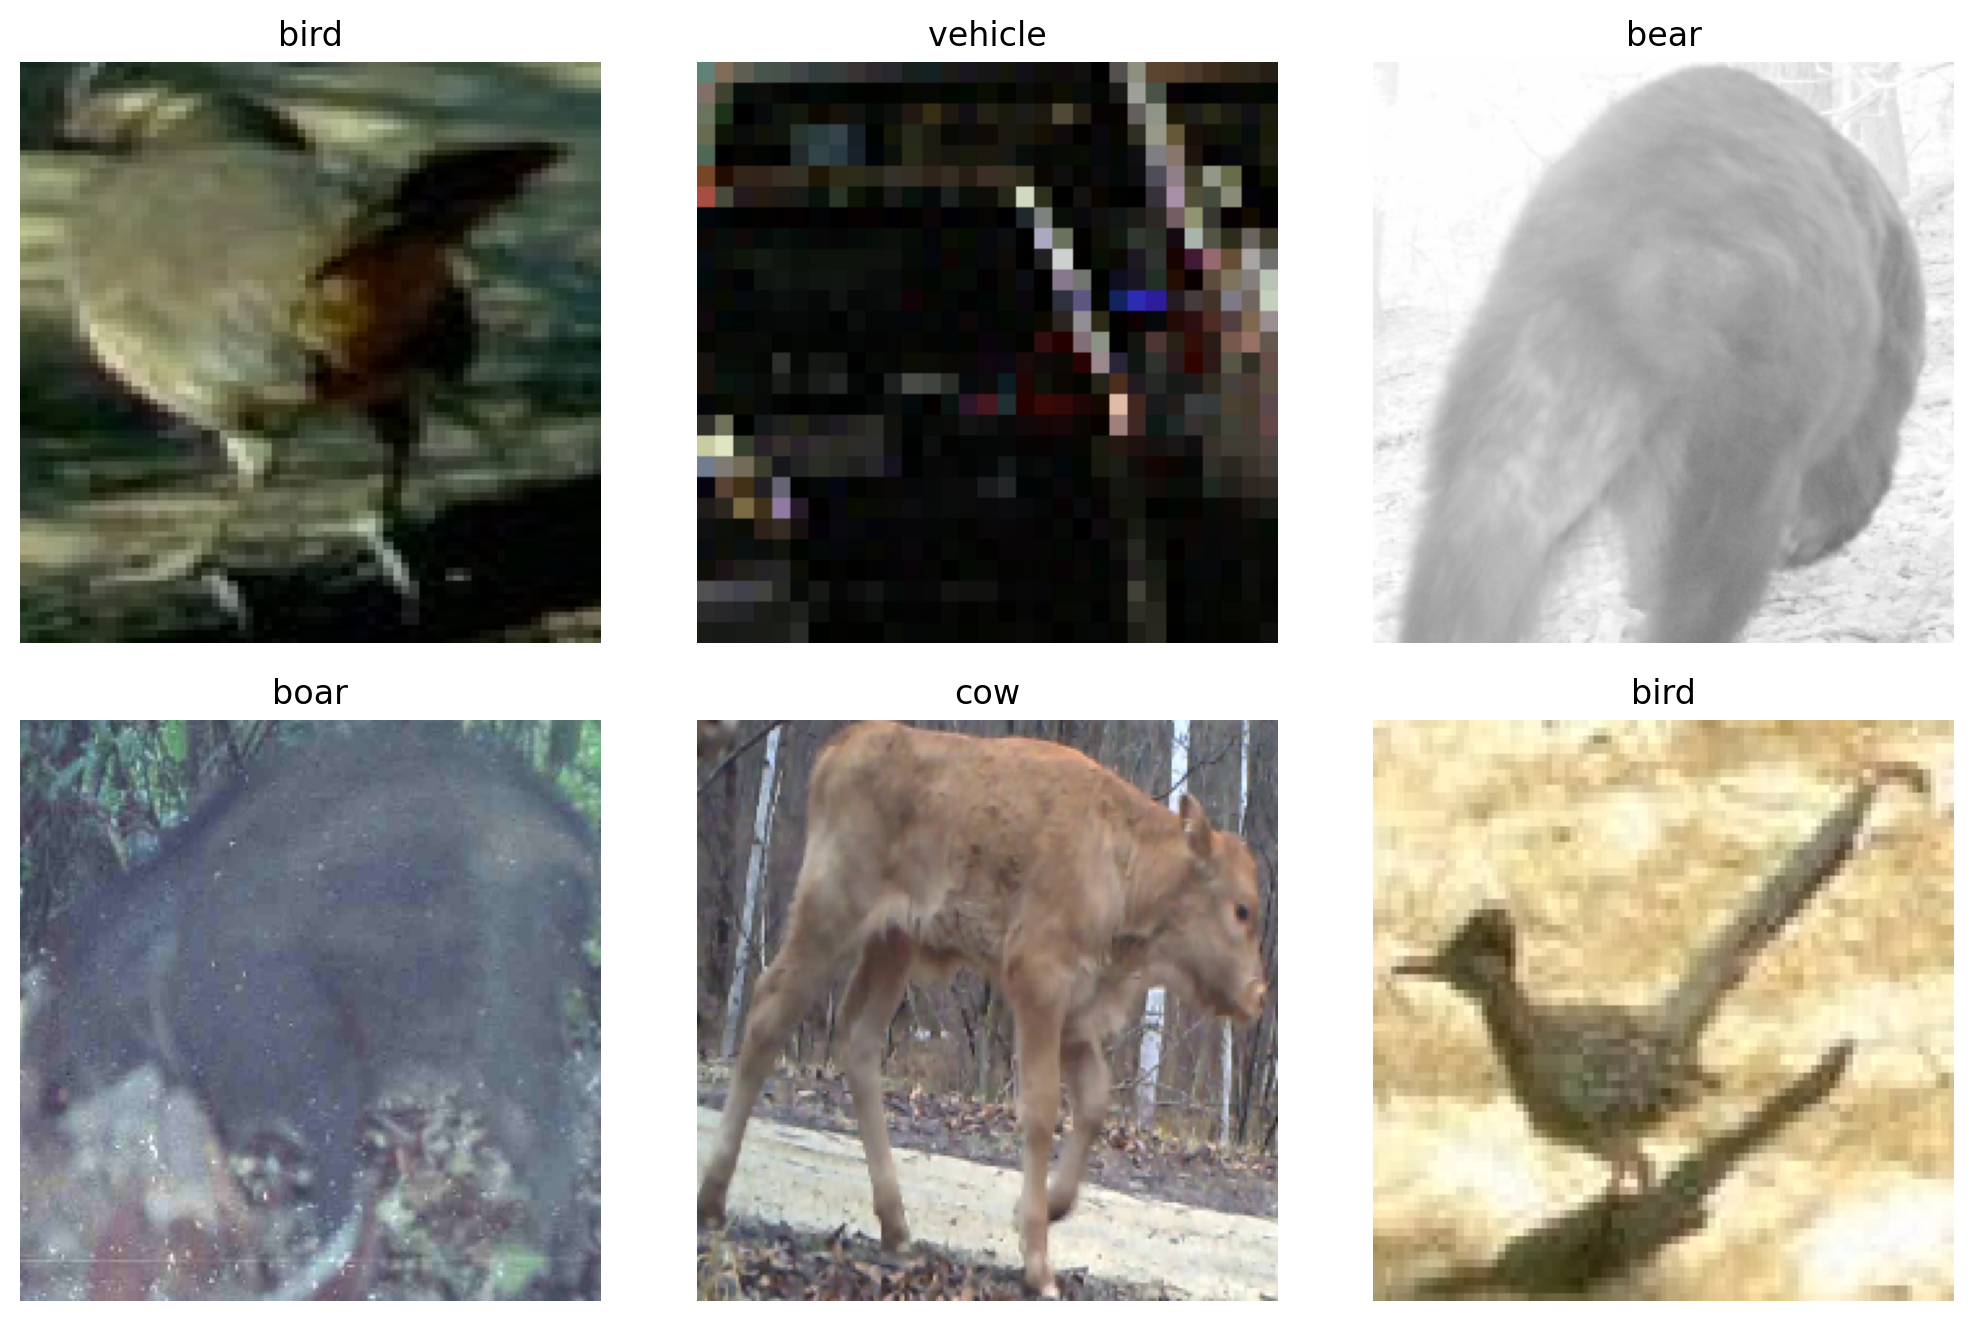

In [43]:
plt.figure(figsize = (10, 10))
for i in range(6):
    batch_index = 0
    images, labels = next(train_generator)
    preprocessed_image = images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(preprocessed_image[batch_index].astype("uint8"))
    plt.title(np.array(LABELS)[labels[batch_index] == 1][0])
    plt.tight_layout()
    plt.axis("off")

In [44]:
# Data augmentation layers.
data_augmentation = keras.Sequential([
                                      layers.RandomRotation(factor = (-0.5, 0.5)),
                                      layers.RandomTranslation(height_factor = (-0.1, 0.1), width_factor = (-0.1, 0.1), fill_mode = "reflect"),
                                      layers.RandomFlip(),
                                      RandomColorDistortion(brightness_delta = (-0.5, 0.5), saturation_delta = (-3, 3)),
                                     ], name = "data_augmentation")

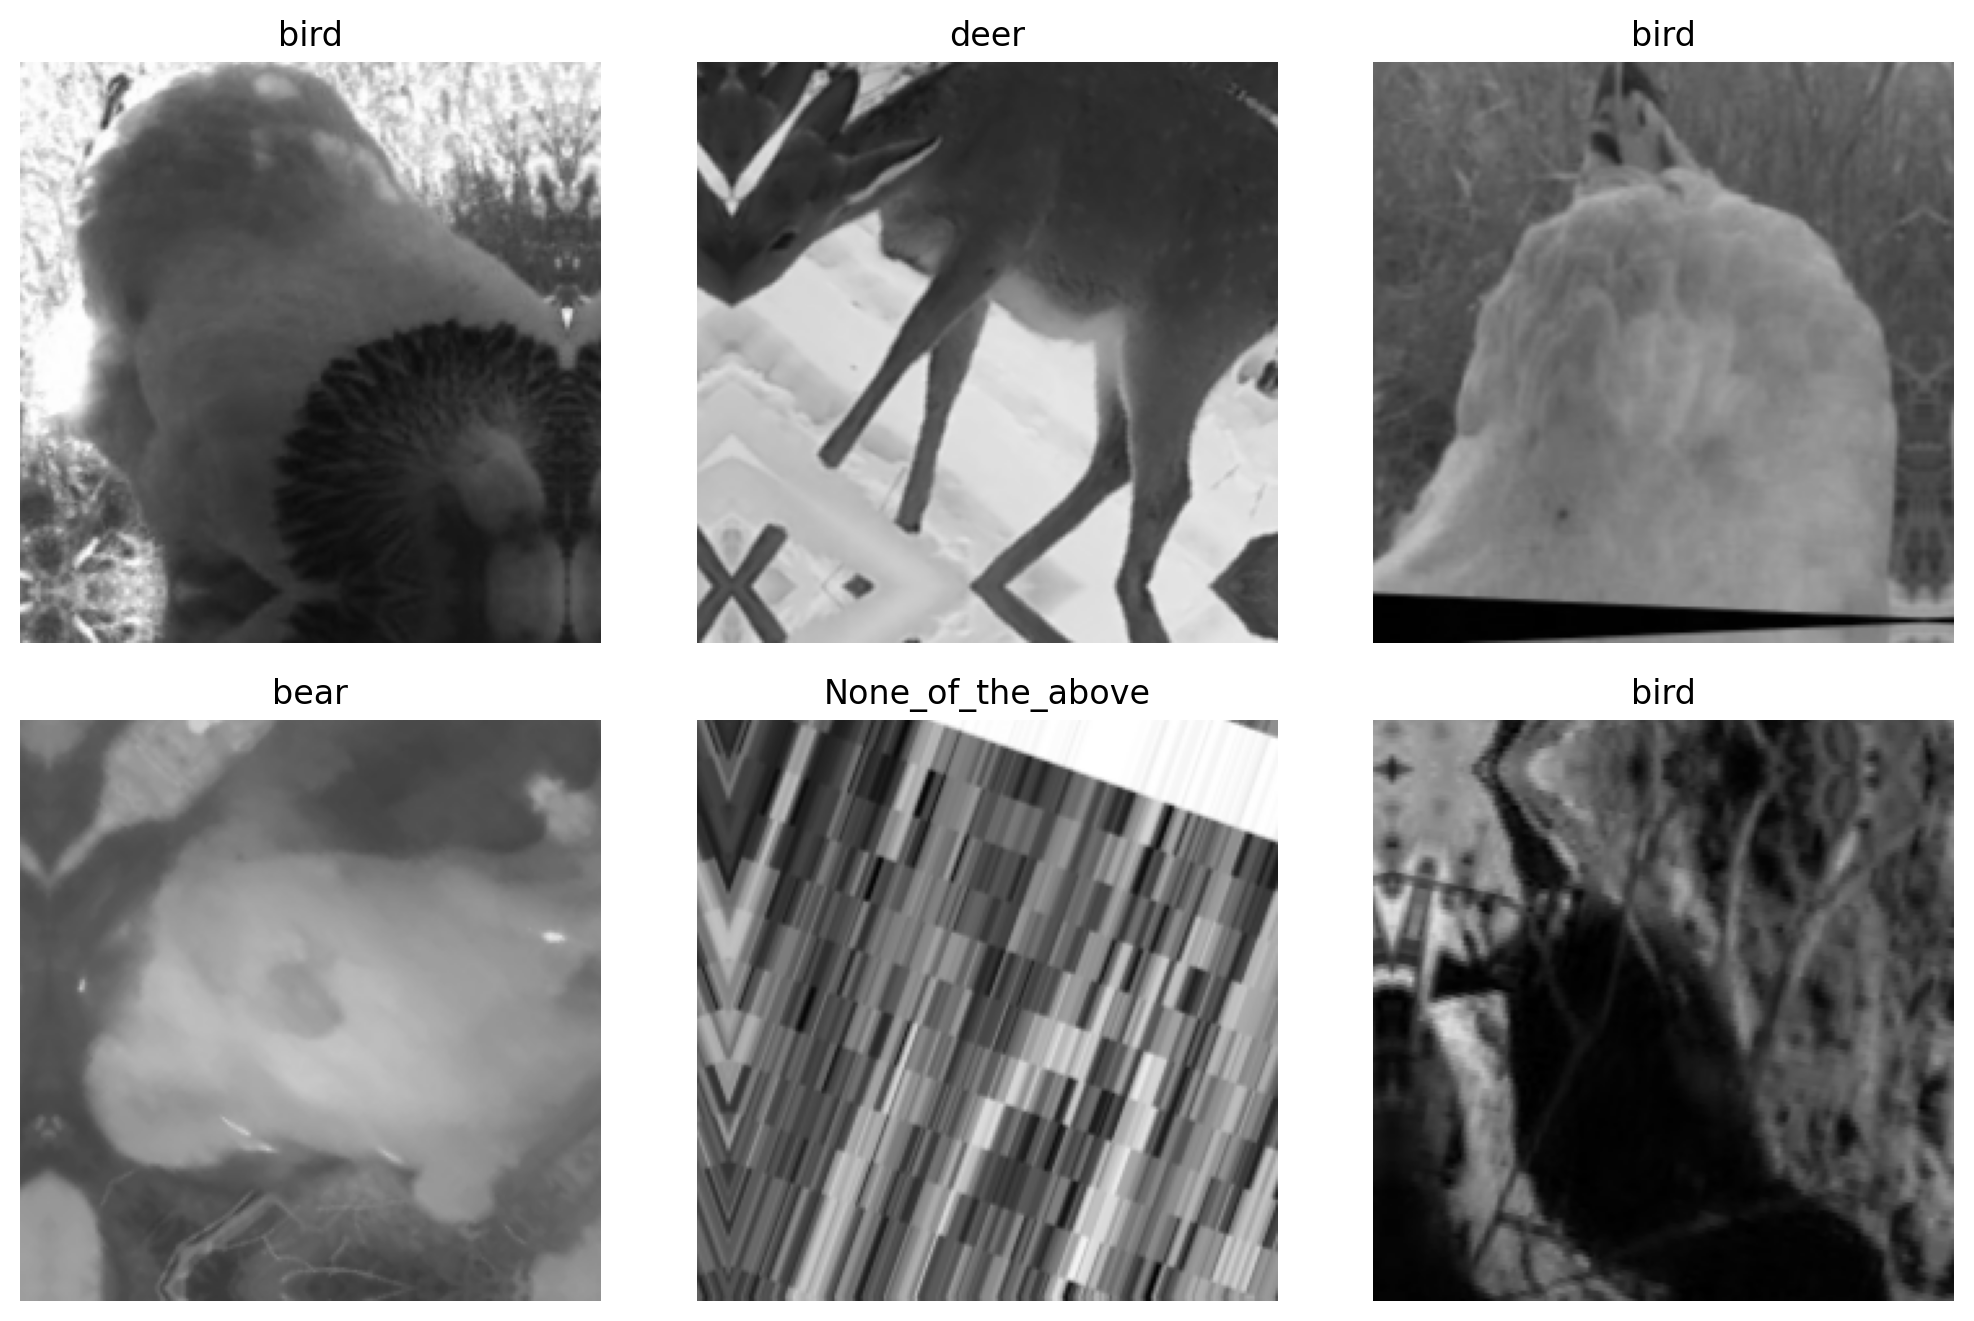

In [45]:
plt.figure(figsize = (10, 10))
for i in range(6):
    batch_index = 0
    images, labels = next(train_generator)
    preprocessed_image = images
    augmented_images = data_augmentation(preprocessed_image)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[batch_index].numpy().astype("uint8"))
    plt.title(np.array(LABELS)[labels[batch_index] == 1][0])
    plt.tight_layout()
    plt.axis("off")

In [ ]:
def schedule(epoch, lr):
    if epoch <= 10:
        lr = 1e-2
    else:
        lr = 1e-3
    return lr

In [32]:
def build_model(num_classes):
    inputs = layers.Input(shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetB0(include_top = False, input_tensor = inputs, weights = "imagenet")

    # Freeze the pretrained weights.
    for layer in model.layers[:-13]:
        layer.trainable = False

    # Rebuild top.
    x = layers.GlobalAveragePooling2D(name = "avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name = "top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation = "softmax", name = "pred")(x)

    # Compile.
    model = tf.keras.Model(inputs, outputs, name = "EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-2)
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    return model

In [33]:
model = build_model(NUM_CLASSES)

In [34]:
epochs = 30

lr_scheduler = LearningRateScheduler(schedule)
history = model.fit(train_generator, validation_data = valid_generator, epochs = epochs, callbacks = [lr_scheduler])

Epoch 1/30
  3/895 [..............................] - ETA: 53:55 - loss: 4.7380 - accuracy: 0.2812 

KeyboardInterrupt: 

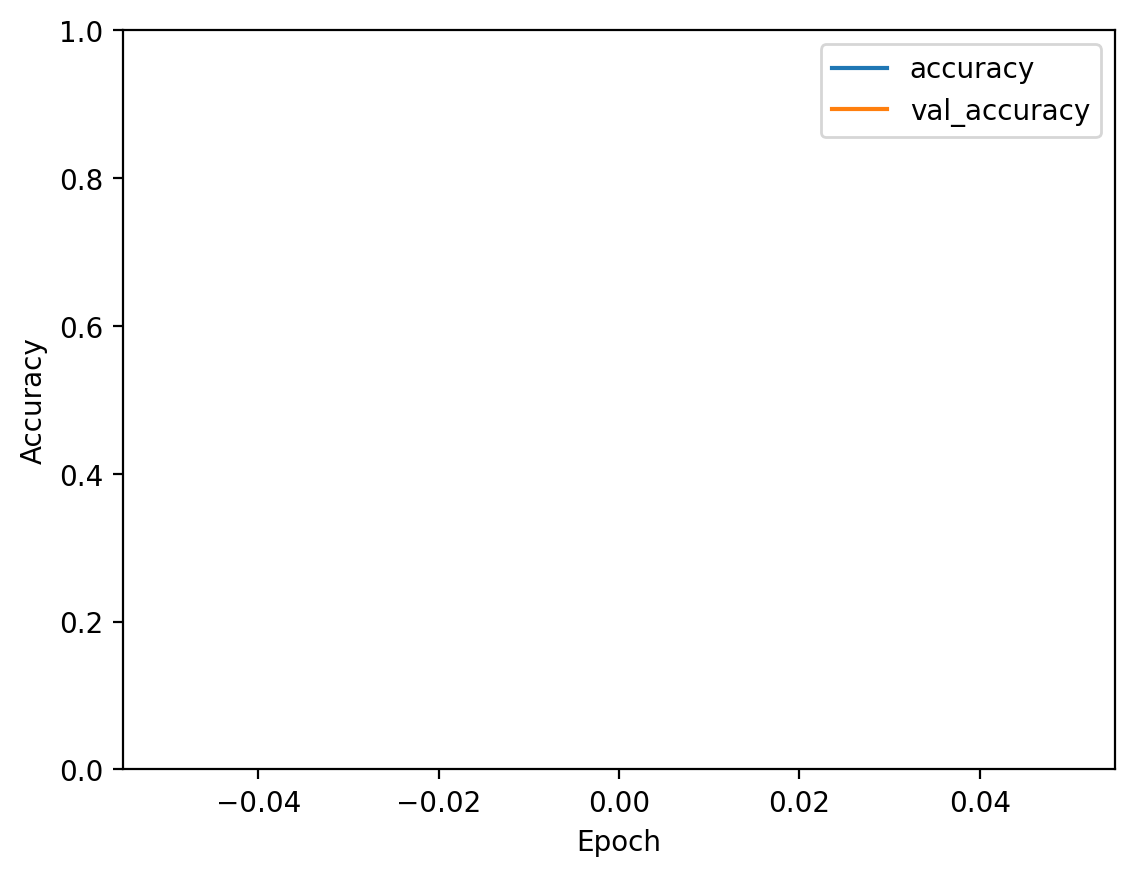

In [102]:
plt.plot(history.history["accuracy"], label = "accuracy")
plt.plot(history.history["val_accuracy"], label = "val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc = "best")

# Inference

In [37]:
path_image_test = "example.jpg"

image = keras.preprocessing.image.load_img(path_image_test, target_size = IMAGE_SIZE, color_mode = COLOR_MODE)
image = keras.preprocessing.image.img_to_array(image)
image = tf.expand_dims(image, 0)  

(-0.5, 223.5, 223.5, -0.5)

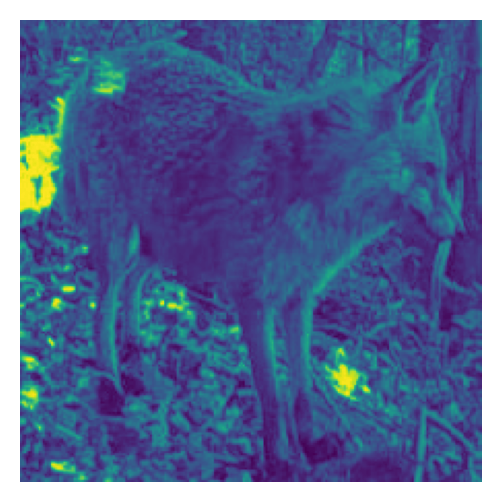

In [38]:
plt.figure(figsize = (3, 3))
plt.imshow(image.numpy().squeeze().astype("uint8"))
plt.axis("off")

In [105]:
predictions = model.predict(image)
predictions

array([[0.66165346, 0.6595645 , 0.3534559 , 0.60526997, 0.41984177,
        0.5630666 , 0.5926579 , 0.26579314, 0.5033767 , 0.13894999,
        0.49279407]], dtype=float32)

In [106]:
np.round(predictions, 2)

array([[0.66, 0.66, 0.35, 0.61, 0.42, 0.56, 0.59, 0.27, 0.5 , 0.14, 0.49]],
      dtype=float32)

In [107]:
train_generator.class_indices

{'badger': 0,
 'bear': 1,
 'boar': 2,
 'cat': 3,
 'cow': 4,
 'deer': 5,
 'dog': 6,
 'fox': 7,
 'hare': 8,
 'human': 9,
 'weasel': 10}